# Zadanie 1: Pomiar czasu dla `fib()`
Porównujemy czas wykonania obliczeń `fib(n)` za pomocą wątków (`threading`) i procesów (`multiprocessing`).

In [1]:
import threading
import multiprocessing as mp
from time import perf_counter
import csv

# Funkcja obliczająca Fibbonaciego (rekurencyjna)
def fib(n):
    return n if n < 2 else fib(n - 2) + fib(n - 1)

# Wersja z threading
def run_threads(n, num_threads=2):
    threads = []
    for _ in range(num_threads):
        threads.append(threading.Thread(target=fib, args=(n,)))
    
    t0 = perf_counter()
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    return perf_counter() - t0

# Wersja z multiprocessing
def run_processes(n, num_procs=2):
    processes = []
    for _ in range(num_procs):
        processes.append(mp.Process(target=fib, args=(n,)))
    
    t0 = perf_counter()
    for p in processes:
        p.start()
    for p in processes:
        p.join()
    return perf_counter() - t0

# Parametry testu
ns = [10, 12, 15]  # wartości n dla fib(n)
repeats = 2        # ile razy powtarzamy każdy test
results = []
test_num = 1

for n in ns:
    for _ in range(repeats):
        czas_thread = round(run_threads(n), 4)
        results.append([test_num, n, "thread", czas_thread])
        
        czas_process = round(run_processes(n), 4)
        results.append([test_num, n, "process", czas_process])
    test_num += 1

# Zapis wyników do pliku CSV
with open("wyniki.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["numer_testu", "fibo_n", "typ", "czas"])
    writer.writerows(results)

# Podgląd wyników
import pandas as pd
df = pd.DataFrame(results, columns=["numer_testu", "fibo_n", "typ", "czas"])
df


,numer_testu,fibo_n,typ,czas
0,1,10,thread,0.0004
1,1,10,process,0.0964
2,1,10,thread,0.0004
3,1,10,process,0.0800
4,2,12,thread,0.0005
5,2,12,process,0.0822
6,2,12,thread,0.0005
7,2,12,process,0.0828
8,3,15,thread,0.0007
9,3,15,process,0.0930


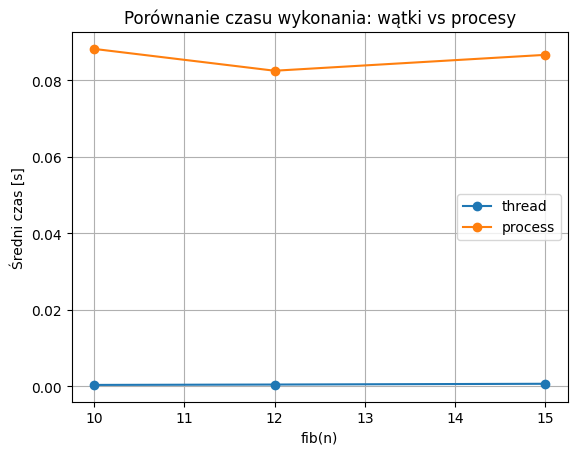

In [3]:

import pandas as pd
import matplotlib.pyplot as plt

# Wczytanie danych
df = pd.read_csv("wyniki.csv")

# Generowanie wykresu
for typ in df["typ"].unique():
    subset = df[df["typ"] == typ].groupby("fibo_n")["czas"].mean()
    plt.plot(subset.index, subset.values, label=typ, marker="o")

plt.xlabel("fib(n)")
plt.ylabel("Średni czas [s]")
plt.title("Porównanie czasu wykonania: wątki vs procesy")
plt.legend()
plt.grid(True)
plt.show()



# Zadanie 2: Pobieranie stron za pomocą ThreadPoolExecutor

In [1]:
# ZADANIE 2
import concurrent.futures
import requests
import os

urls = [
    ("https://www.python.org", "python.html"),
    ("https://www.wikipedia.org", "wikipedia.html"),
    ("https://www.openai.com", "openai.html"),
    ("https://www.github.com", "github.html"),
    ("https://www.stackoverflow.com", "stackoverflow.html")
]

def fetch_and_save(url_filename):
    url, filename = url_filename
    response = requests.get(url)
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
    print(f"Pobrano: {url}")

max_workers = os.cpu_count() // 2 or 1

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    executor.map(fetch_and_save, urls)


Pobrano: https://www.openai.com
Pobrano: https://www.wikipedia.org
Pobrano: https://www.python.org
Pobrano: https://www.github.com
Pobrano: https://www.stackoverflow.com


# Zadanie 3: Wczytanie i scalanie danych z ProcessPoolExecutor

In [6]:

import pandas as pd
import numpy as np
import time
from concurrent.futures import ProcessPoolExecutor

def load_csv(file):
    return pd.read_csv(file)

if __name__ == "__main__":
    # Mniejsza liczba rekordów na plik - 1 milion
    n = 1_000_000

    # Generowanie danych
    for i in range(4):
        df = pd.DataFrame({
            "id": np.arange(i * n, (i + 1) * n),
            "value": np.random.rand(n)
        })
        df.to_csv(f"data_{i}.csv", index=False)

    # Sekwencyjne wczytanie i scalanie
    t0 = time.perf_counter()
    dfs = [pd.read_csv(f"data_{i}.csv") for i in range(4)]
    df_all = pd.concat(dfs, ignore_index=True)
    print(f"Sekwencyjne scalanie: {round(time.perf_counter() - t0, 2)} sek")

    # Wczytanie i scalanie z użyciem ProcessPoolExecutor
    t0 = time.perf_counter()
    with ProcessPoolExecutor() as executor:
        dfs_parallel = list(executor.map(load_csv, [f"data_{i}.csv" for i in range(4)]))
    df_all_parallel = pd.concat(dfs_parallel, ignore_index=True)
    print(f"Równoległe scalanie: {round(time.perf_counter() - t0, 2)} sek")


Sekwencyjne scalanie: 1.0 sek


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.